In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting

## Fruit 360 Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# location on Google Drive
master_path = '/content/drive/My Drive/Colab Notebooks/fruit360_v3/656/'

# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3, fill=0), 
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(master_path, transform=transform)
train_size = int(0.6 * (len(dataset)))
val_size = int(0.25 * (len(dataset)))
test_size = len(dataset) - train_size - val_size
print (train_size, val_size, test_size)
# assumes three folders with 60% training, 25% validation and 15% testing samples
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print (len(train_dataset), len(val_dataset), len(test_dataset))
#test_dataset = torchvision.datasets.ImageFolder(master_path + 'Test', transform=transform)

35055 14606 8764
35055 14606 8764


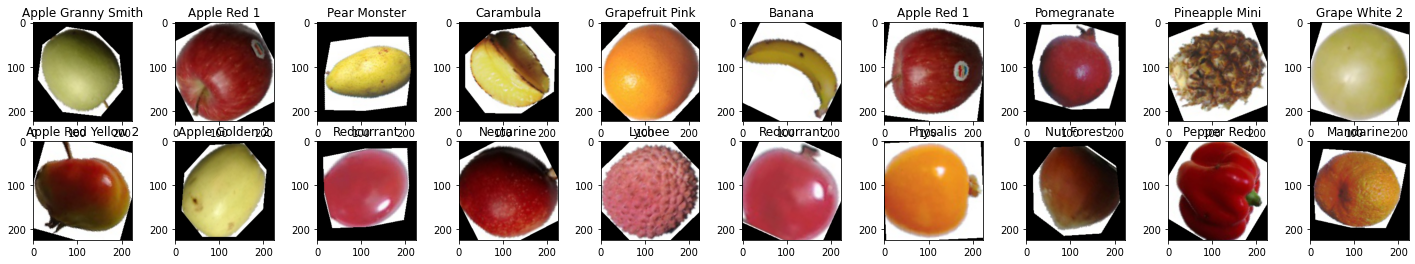

In [ ]:
# Prepare Dataloader
batch_size = 27
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)


# Visualize some sample data
classes = ['Apple Braeburn', 'Apple Golden 2', 'Apple Granny Smith', 
            'Apple Red 1', 'Apple Red 2', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 
            'Apricot', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 
            'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 
            'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Fig', 
            'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 
            'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kumquats', 
            'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 
            'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Papaya', 'Passion Fruit', 'Peach', 
            'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 
            'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 
            'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 3', 'Pomegranate', 
            'Quince', 'Rambutan', 'Raspberry', 
            'Redcurrant', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 
            'Tomato Cherry Red', 'Tomato Heart', 'Walnut']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1)
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Fruit 360 Transfer Learning

In [ ]:
import torchvision.models
vgg = torchvision.models.vgg16(pretrained=True)

In [ ]:
import os
# location on Google Drive
master_path = '/content/drive/My Drive/Colab Notebooks/fruit360_v3/VGG'
classes = ['Apple Braeburn', 'Apple Golden 2', 'Apple Granny Smith', 
            'Apple Red 1', 'Apple Red 2', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 
            'Apricot', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 
            'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 
            'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Fig', 
            'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 
            'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kumquats', 
            'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 
            'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Papaya', 'Passion Fruit', 'Peach', 
            'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 
            'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 
            'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 3', 'Pomegranate', 
            'Quince', 'Rambutan', 'Raspberry', 
            'Redcurrant', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 
            'Tomato Cherry Red', 'Tomato Heart', 'Walnut']

batch_size = 1
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [ ]:
for img, label in train_loader:
  features = vgg.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  print(features_tensor.shape)
  break

torch.Size([1, 512, 7, 7])


In [ ]:
# save features to folder as tensors
n = 0
print("Start saving for train")
for img, label in train_loader:
  features = googlenet_forward(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = master_path + '/train/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1
  if n % 500 == 0:
    print (n, "train features extracted")

print("Finish saving for train")

n = 0
print("Start saving for val")
for img, label in val_loader:
  features = googlenet_forward(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/validation/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1
  if n % 500 == 0:
    print (n, "val features extracted")

print("Finish saving for val")

n = 0
print("Start saving for test")
for img, label in test_loader:
  features = googlenet_forward(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/test/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1
  if n % 500 == 0:
    print (n, "test features extracted")
print("Finish saving for test")

Start saving for train
500 train features extracted
1000 train features extracted
1500 train features extracted
2000 train features extracted
2500 train features extracted
3000 train features extracted
3500 train features extracted
4000 train features extracted
4500 train features extracted
5000 train features extracted
5500 train features extracted
6000 train features extracted
6500 train features extracted
7000 train features extracted
7500 train features extracted
8000 train features extracted
8500 train features extracted
9000 train features extracted
9500 train features extracted
10000 train features extracted
10500 train features extracted
11000 train features extracted
11500 train features extracted
12000 train features extracted
12500 train features extracted
13000 train features extracted
13500 train features extracted
14000 train features extracted
14500 train features extracted
15000 train features extracted
15500 train features extracted
16000 train features extracted
16500

In [ ]:
# Load Tensor Files (features) from folder
master_path = '/content/drive/My Drive/Colab Notebooks/fruit360_v3/VGG'
#load features
# location on Google Drive
train_feature_dataset = torchvision.datasets.DatasetFolder(master_path + '/' + 'train', loader=torch.load, extensions=('.tensor'))
val_feature_dataset = torchvision.datasets.DatasetFolder(master_path + '/' + 'validation', loader=torch.load, extensions=('.tensor'))
test_feature_dataset = torchvision.datasets.DatasetFolder(master_path + '/' + 'test', loader=torch.load, extensions=('.tensor'))

print (len(train_feature_dataset))
print (len(val_feature_dataset))
print (len(test_feature_dataset))
# Prepare Dataloader
batch_size = 32
num_workers = 1

#train feature loader
train_feature_loader = torch.utils.data.DataLoader(train_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(train_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

#validation feature loader
val_feature_loader = torch.utils.data.DataLoader(val_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(val_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

#test feature loader
test_feature_loader = torch.utils.data.DataLoader(test_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(test_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

35055
14606
8764
torch.Size([32, 1024, 1, 1])
torch.Size([32])
torch.Size([32, 1024, 1, 1])
torch.Size([32])
torch.Size([32, 1024, 1, 1])
torch.Size([32])


In [ ]:
class CNN_feedGoogle(nn.Module):
      def __init__(self):
          self.name = "CNN_feedGoogle_89"
          super(CNN_feedGoogle, self).__init__()
          self.fc1 = nn.Linear(1024, 768)
          self.fc2 = nn.Linear(768, 89)
      def forward(self, x):
          x = x.view(-1, 1024)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    tune_loss = np.loadtxt("{}_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Training Loss")
    plt.plot(range(1,n+1), tune_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train_google(model, train_dataset, val_dataset, batch_size=27, num_epochs=1, learn_rate = 0.001):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss() #We use CrossEntropyLoss as this is a classification problem, and more than 2 classes
    optimizer = optim.Adam(model.parameters(), lr=learn_rate) #Adam optimizer has lower training cost than others such as SGD

    train_acc, val_acc, tune_loss = [], [], []
    num_workers = 1
    train_feature_loader = torch.utils.data.DataLoader(train_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_feature_loader = torch.utils.data.DataLoader(val_feature_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_feature_loader):
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch
          n += 1
        # track accuracy
        train_acc.append(get_accuracy(model, train_feature_loader))
        val_acc.append(get_accuracy(model, val_feature_loader))
        tune_loss.append(float(loss)/batch_size)
        print(epoch, train_acc[-1], val_acc[-1], tune_loss[-1])
        # Save the current model (checkpoint) to a file
        model_path  = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_loss.csv".format(model_path), tune_loss)

In [ ]:
use_cuda = True

model_google = CNN_feedGoogle()

if use_cuda and torch.cuda.is_available():
  model_google.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_google(model_google, train_feature_dataset, val_feature_dataset, batch_size=32, num_epochs=30, learn_rate=0.005)
model_path = "model_CNN_feedGoogle_89_bs32_lr0.005_epoch29"
plot_training_curve(model_path)

In [ ]:
test_feature_loader = torch.utils.data.DataLoader(test_feature_dataset, batch_size=64, 
                                           num_workers=1, shuffle=True)
test_accu = get_accuracy(model_ALEX, test_feature_loader)
print("Test accuracy is", test_accu)